In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [5, 10, 15, 20, 25, 30, 35, 40]
#templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.3, 20, 25, 30, 35, 40]
badchannels = [18, 29, 37, 38, 44, 58]
runlist = [
#           [1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595],
#           [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582],
#           [1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           [1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556],    
           [1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542],  
           [1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525],
           [1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
           [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465],
           [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506]   
          ]
        
        
bias = np.array([
#                 [51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
#                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
#                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 
                               'Vbd', 'spe_3V_over', 'spe_54V_fix', 'spe_55V_fix', 'spe_60V_fix', 'spe_65V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("PE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_54V_fix': slope*54+intercept,
                       'spe_55V_fix': slope*55+intercept, 'spe_60V_fix': slope*60+intercept, 'spe_65V_fix': slope*65+intercept}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

Bad channel: 58


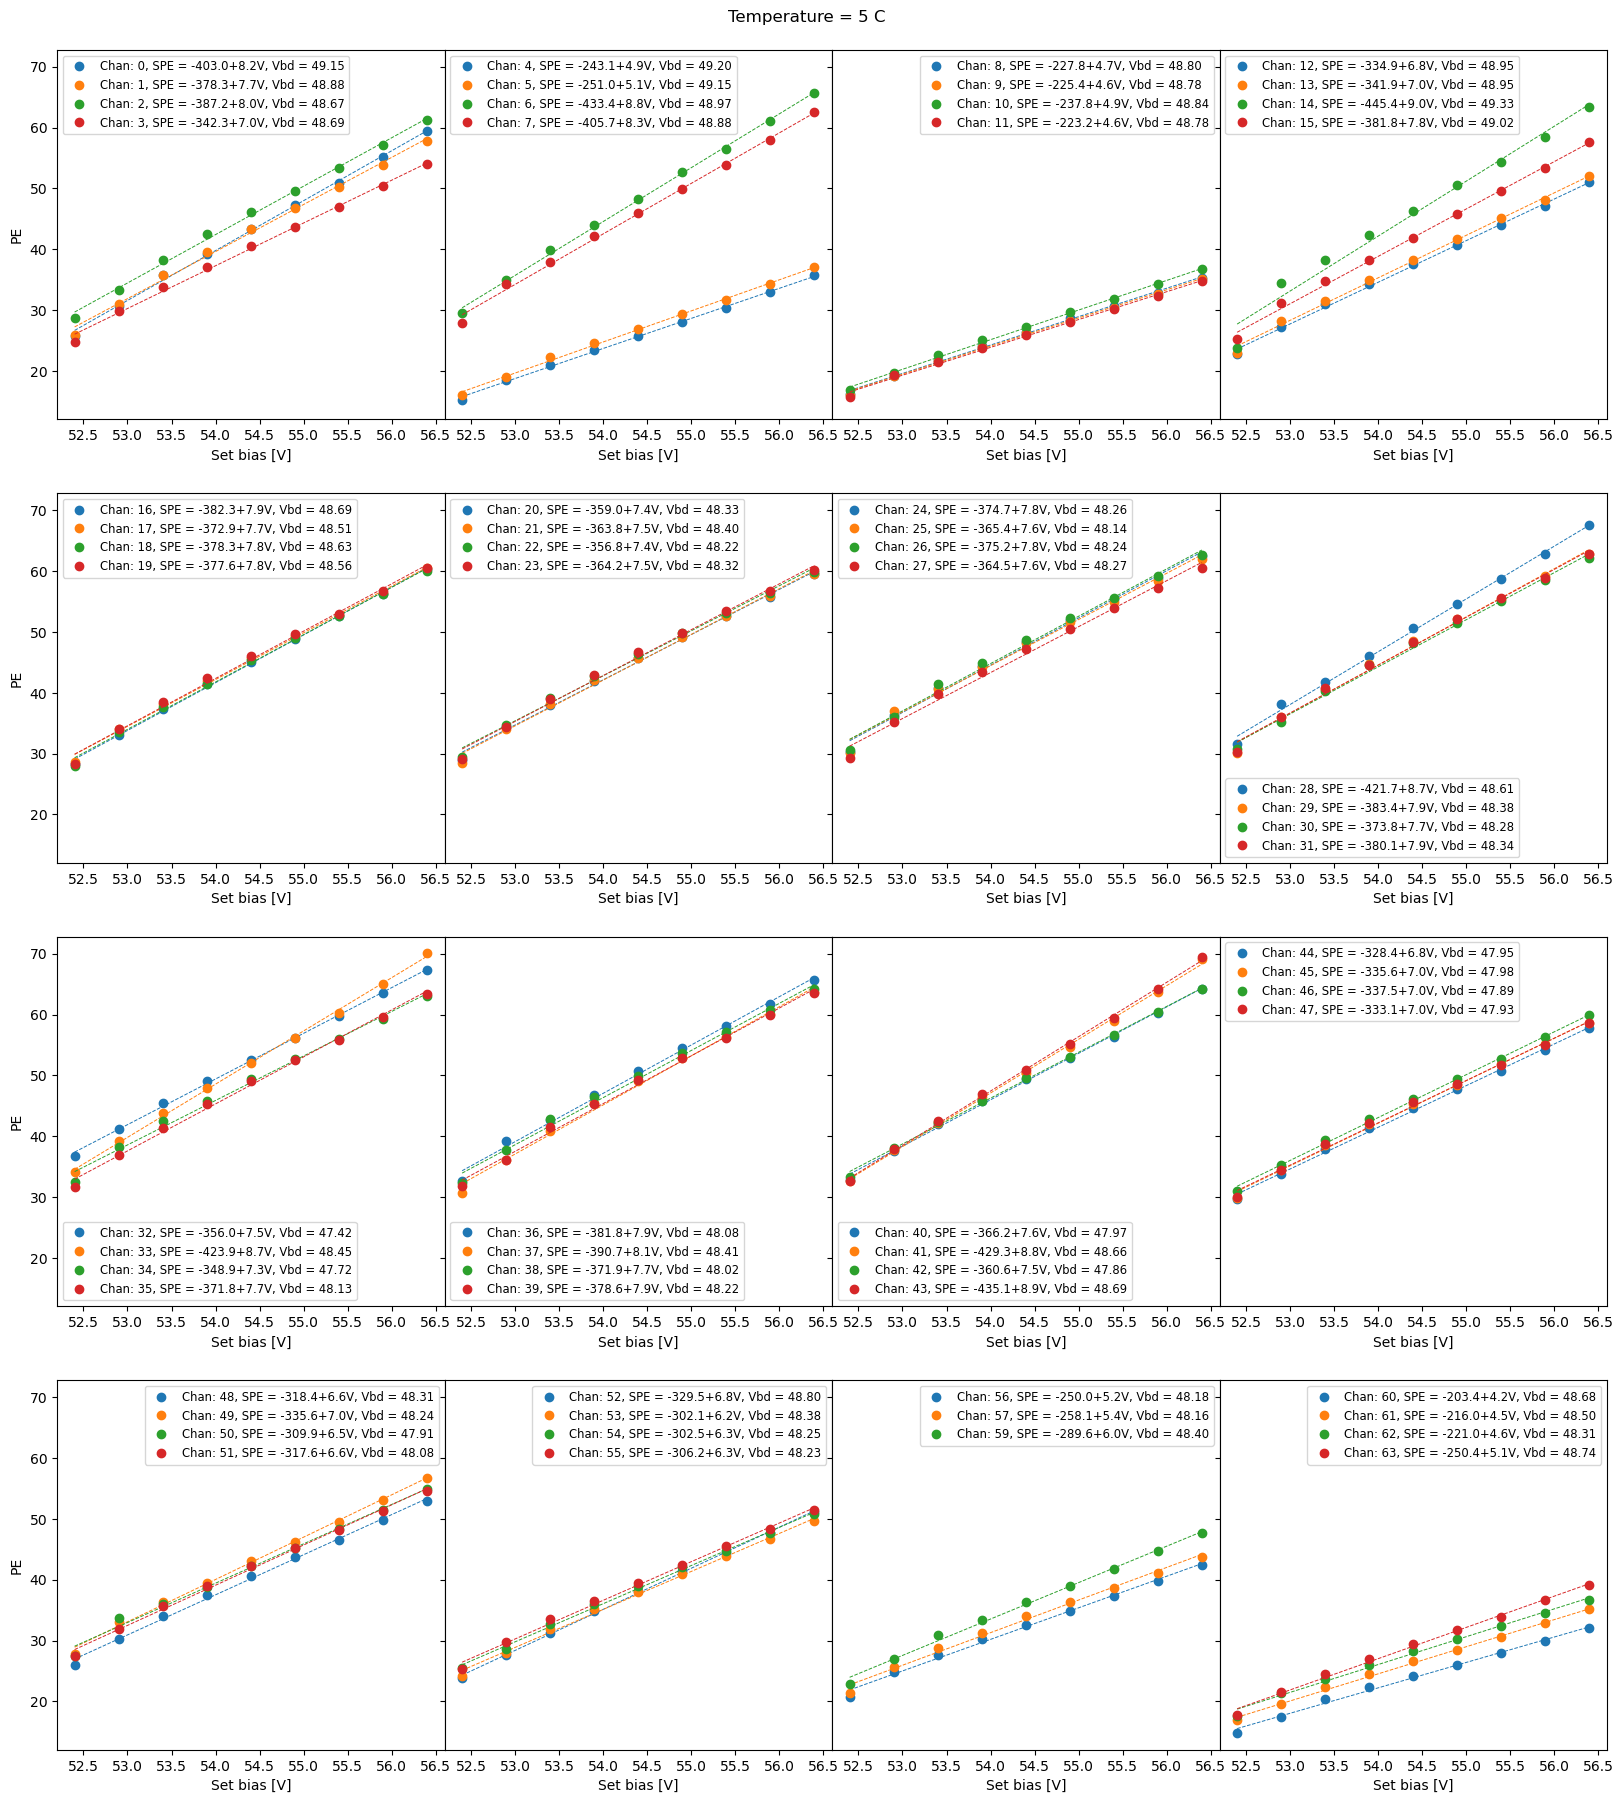

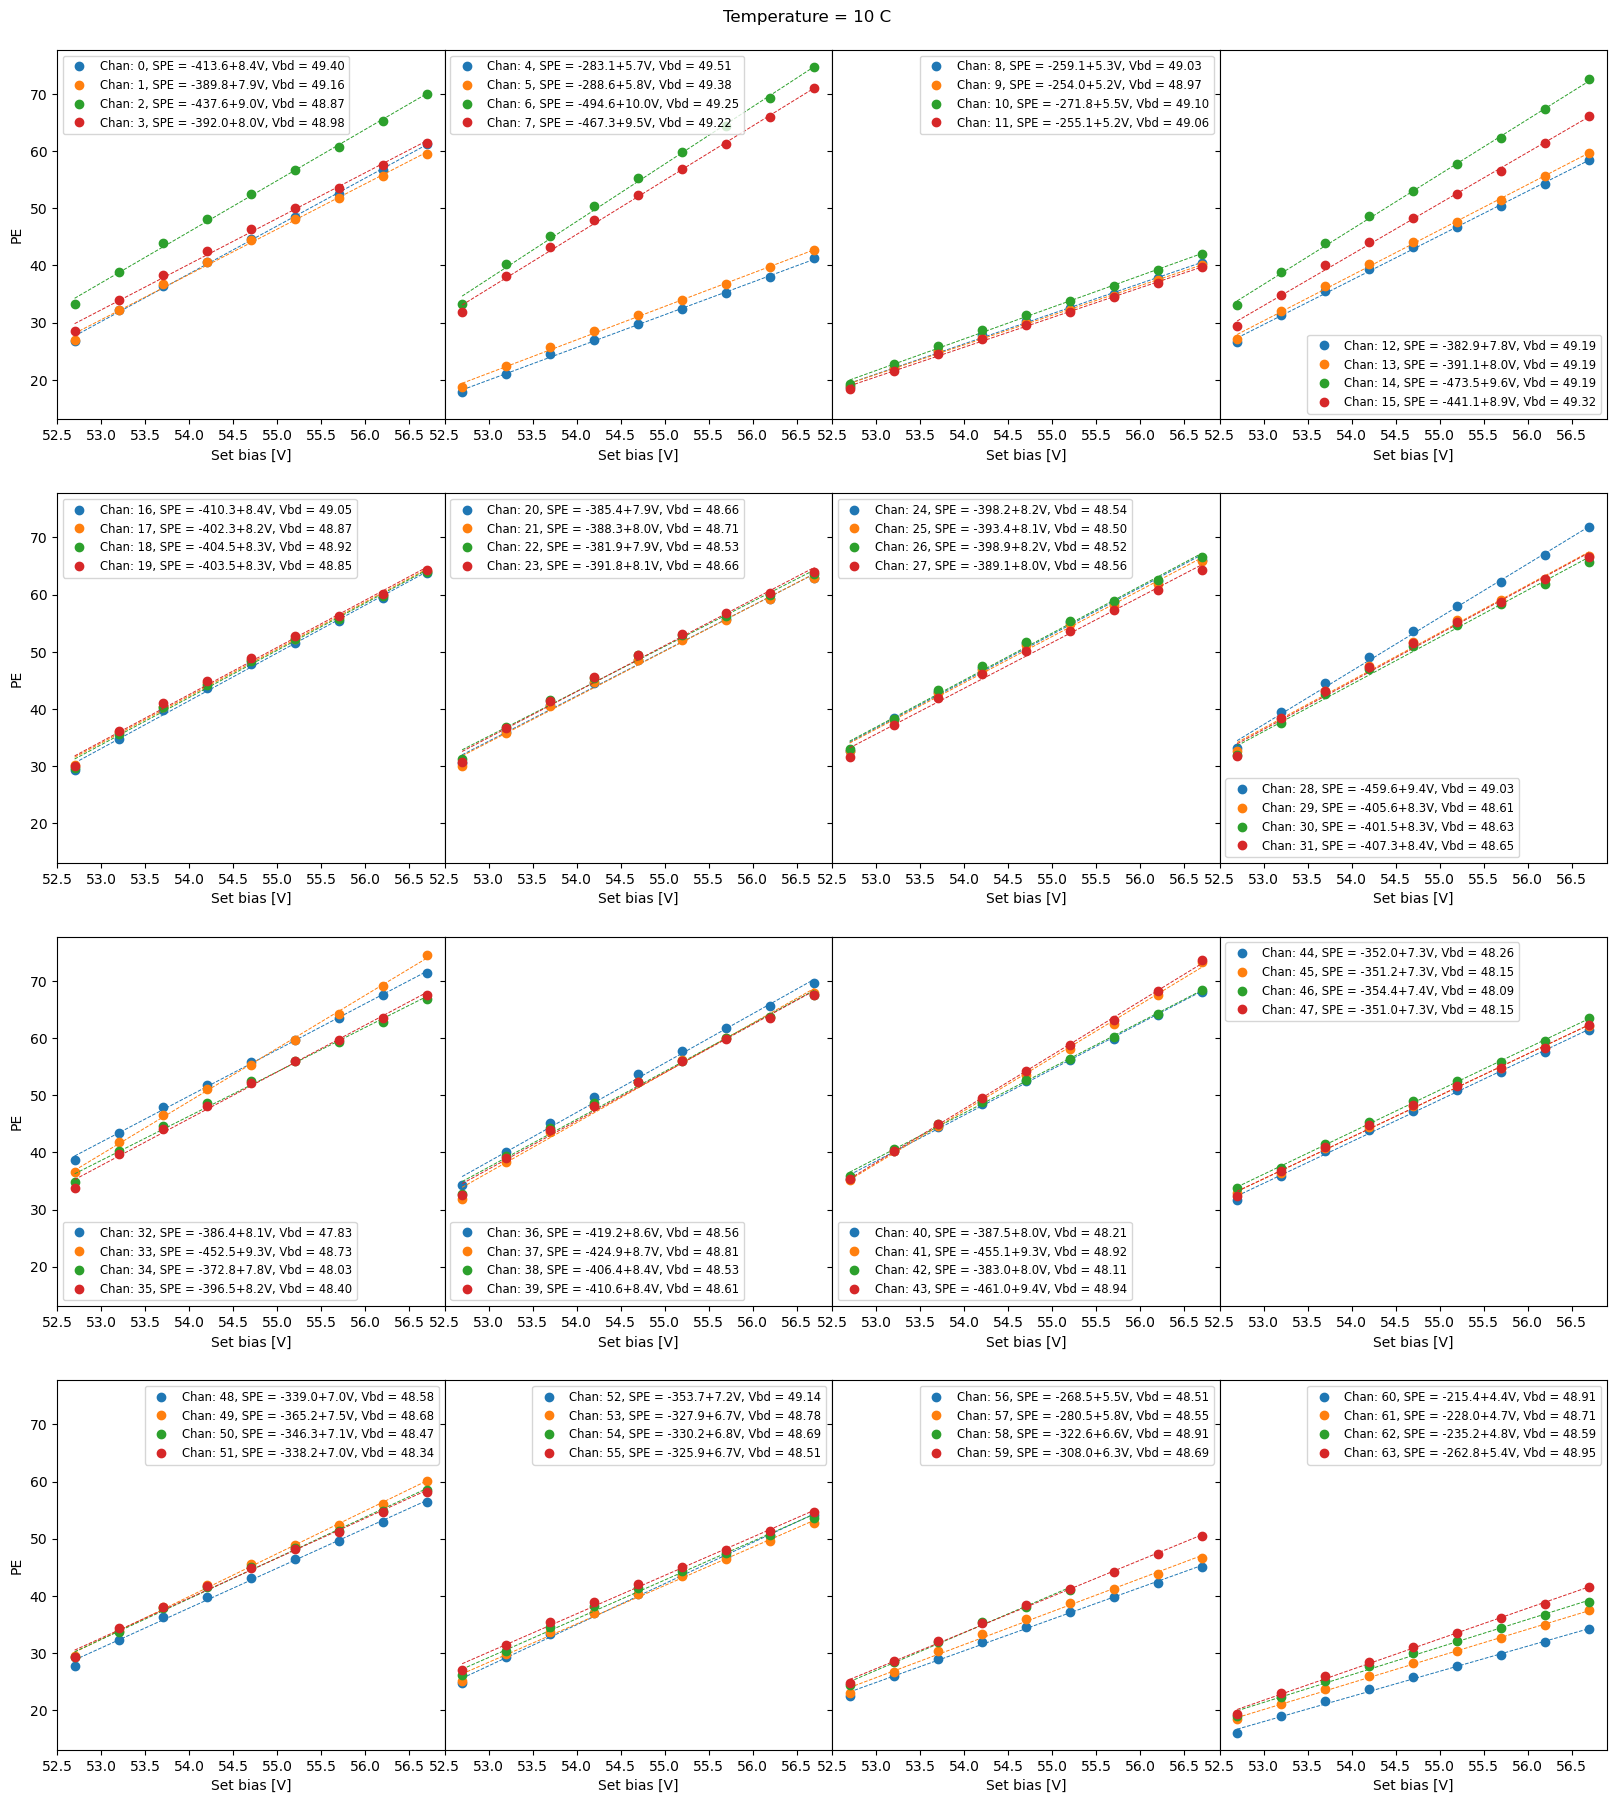

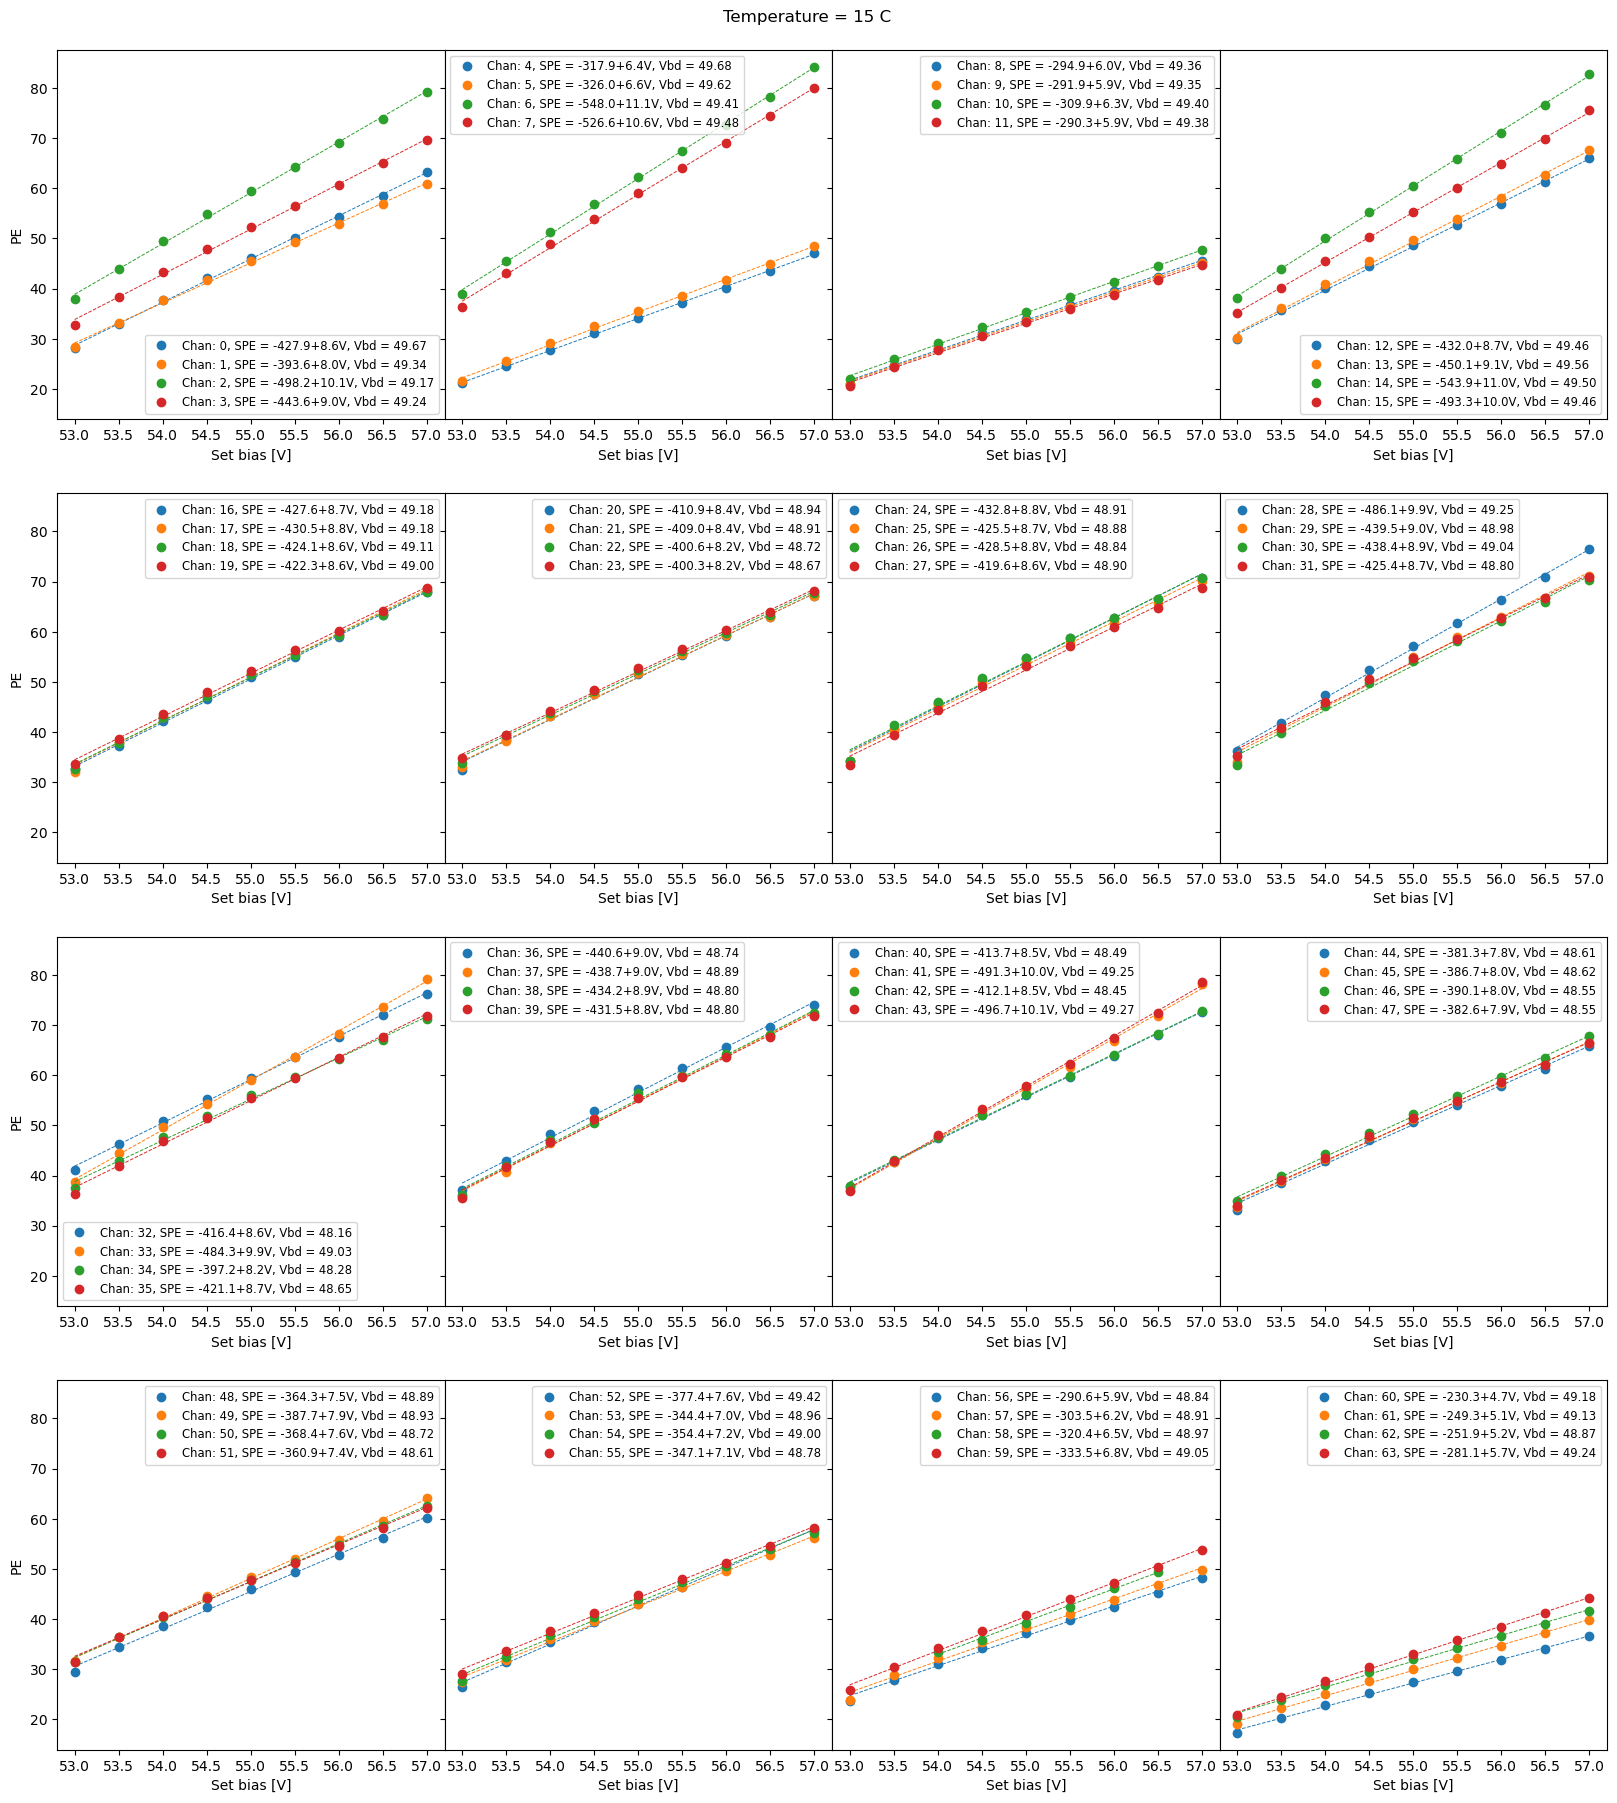

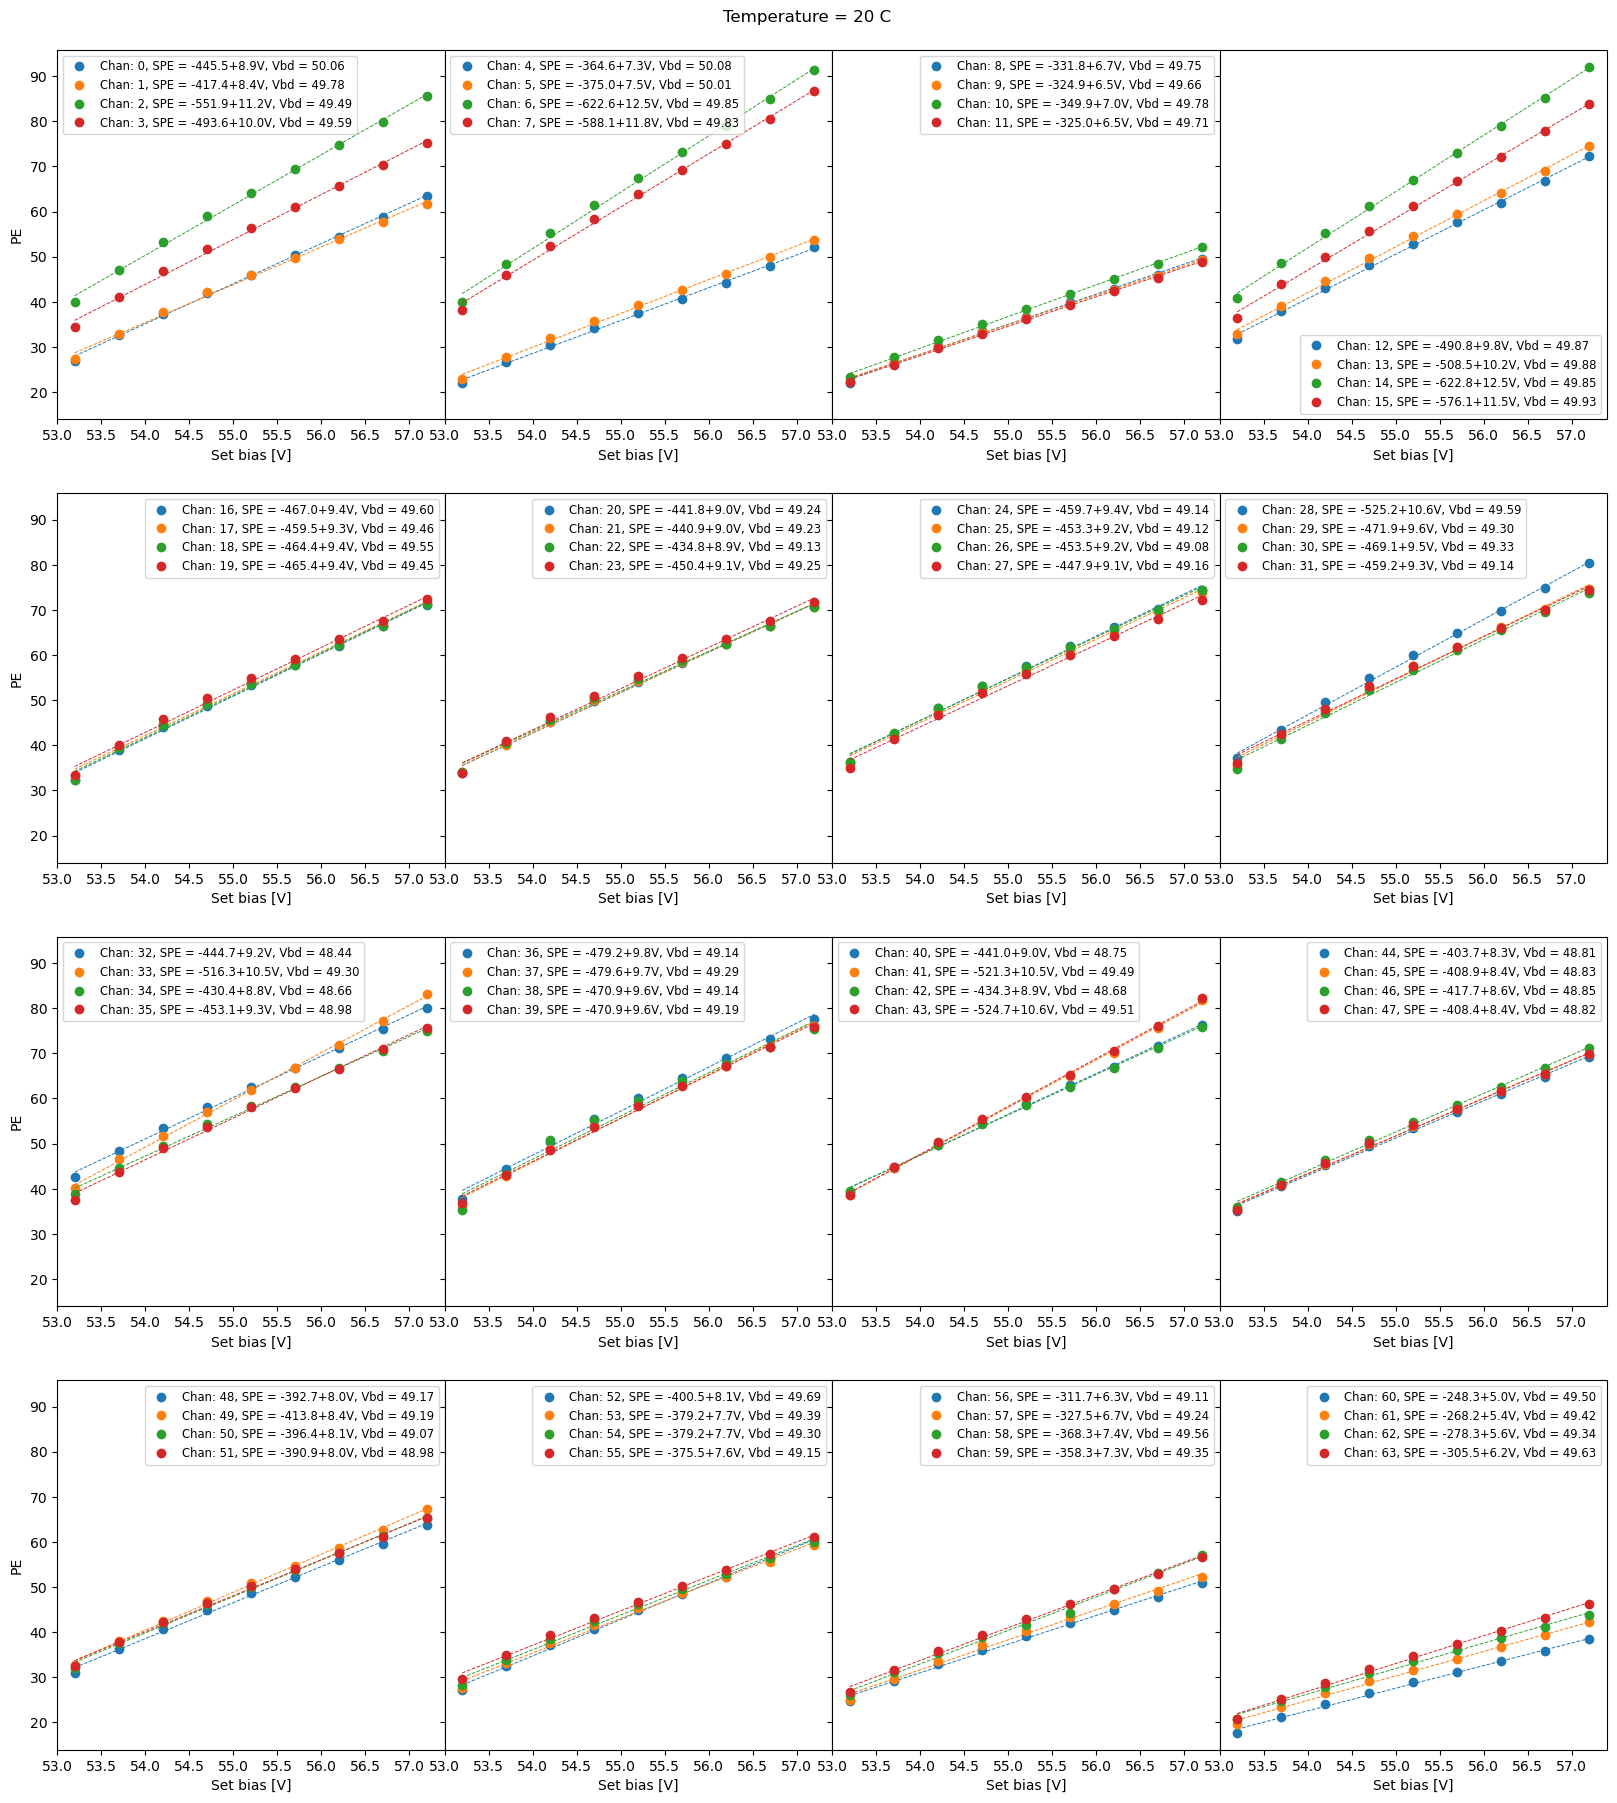

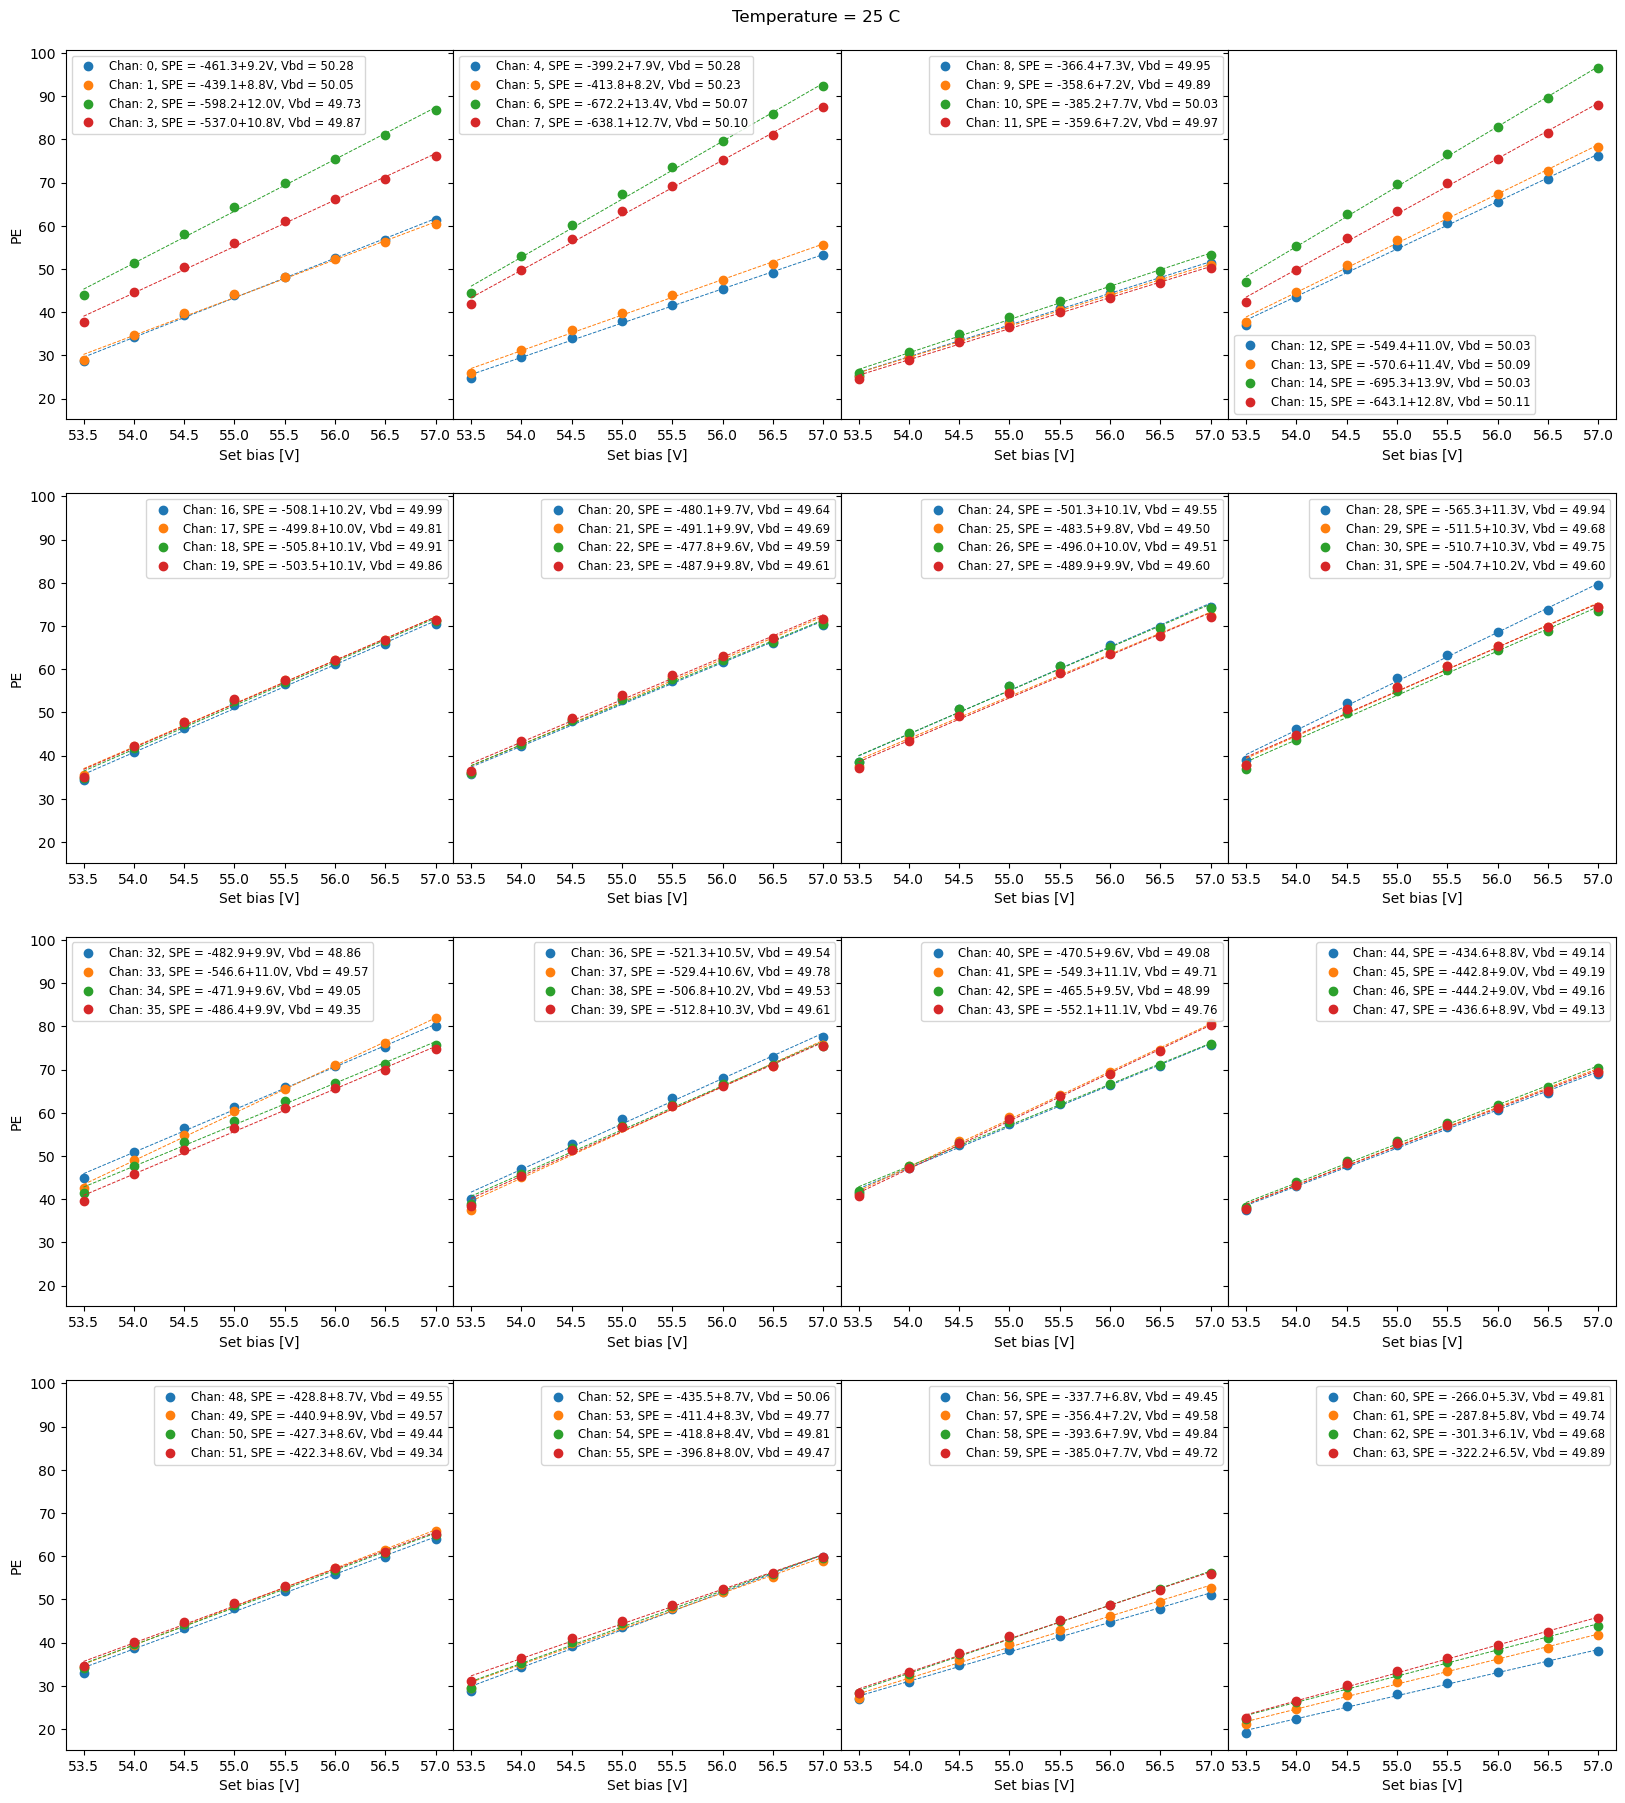

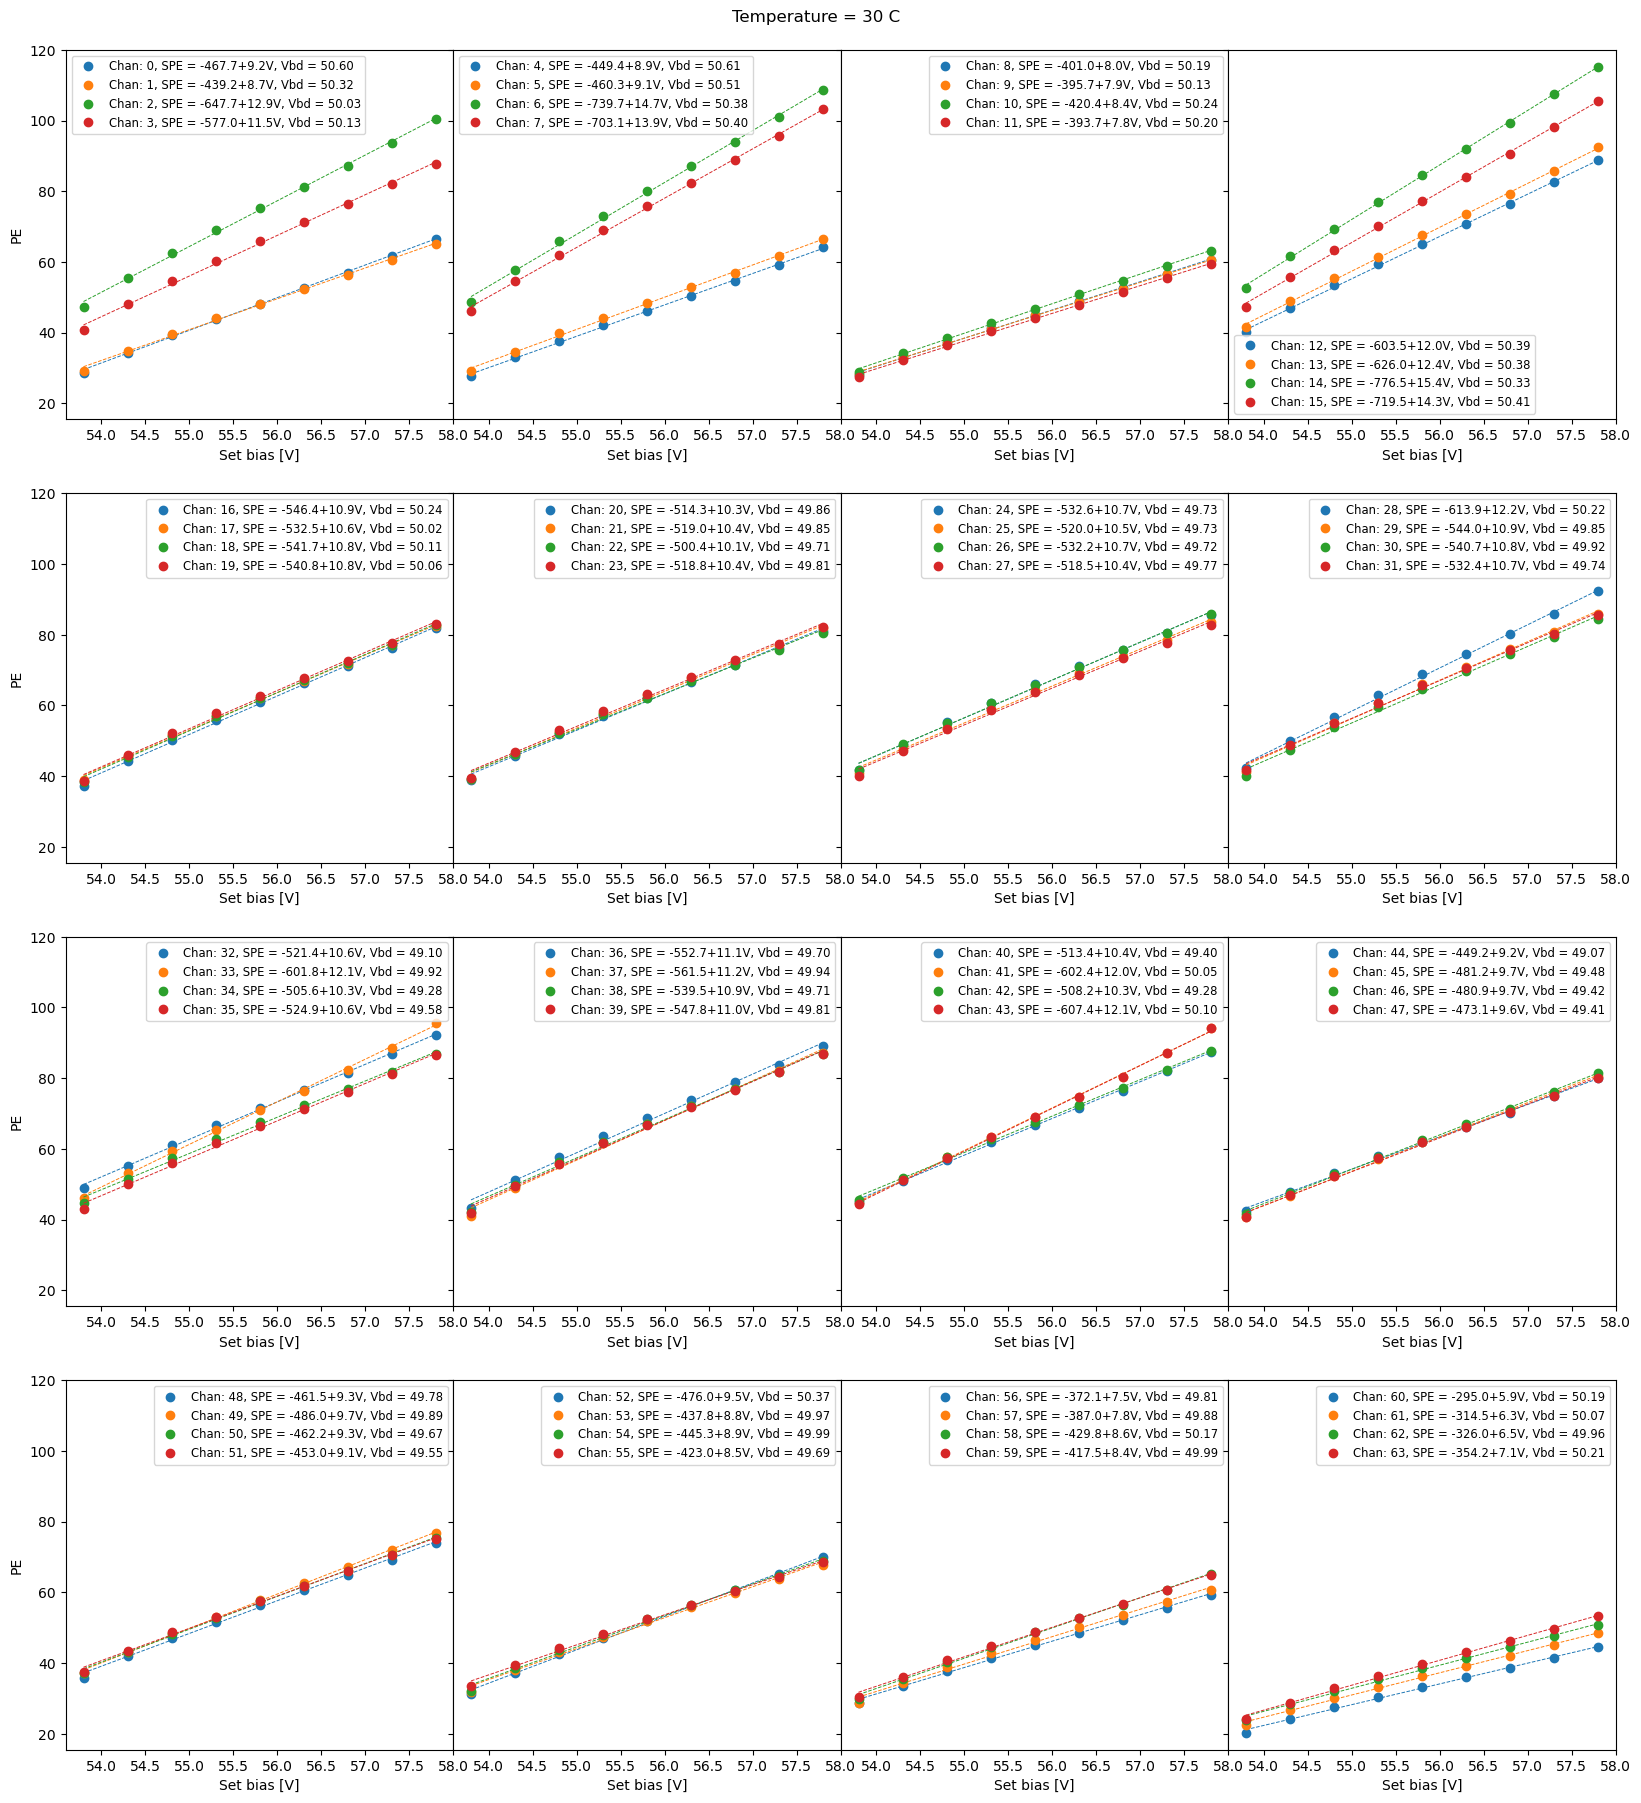

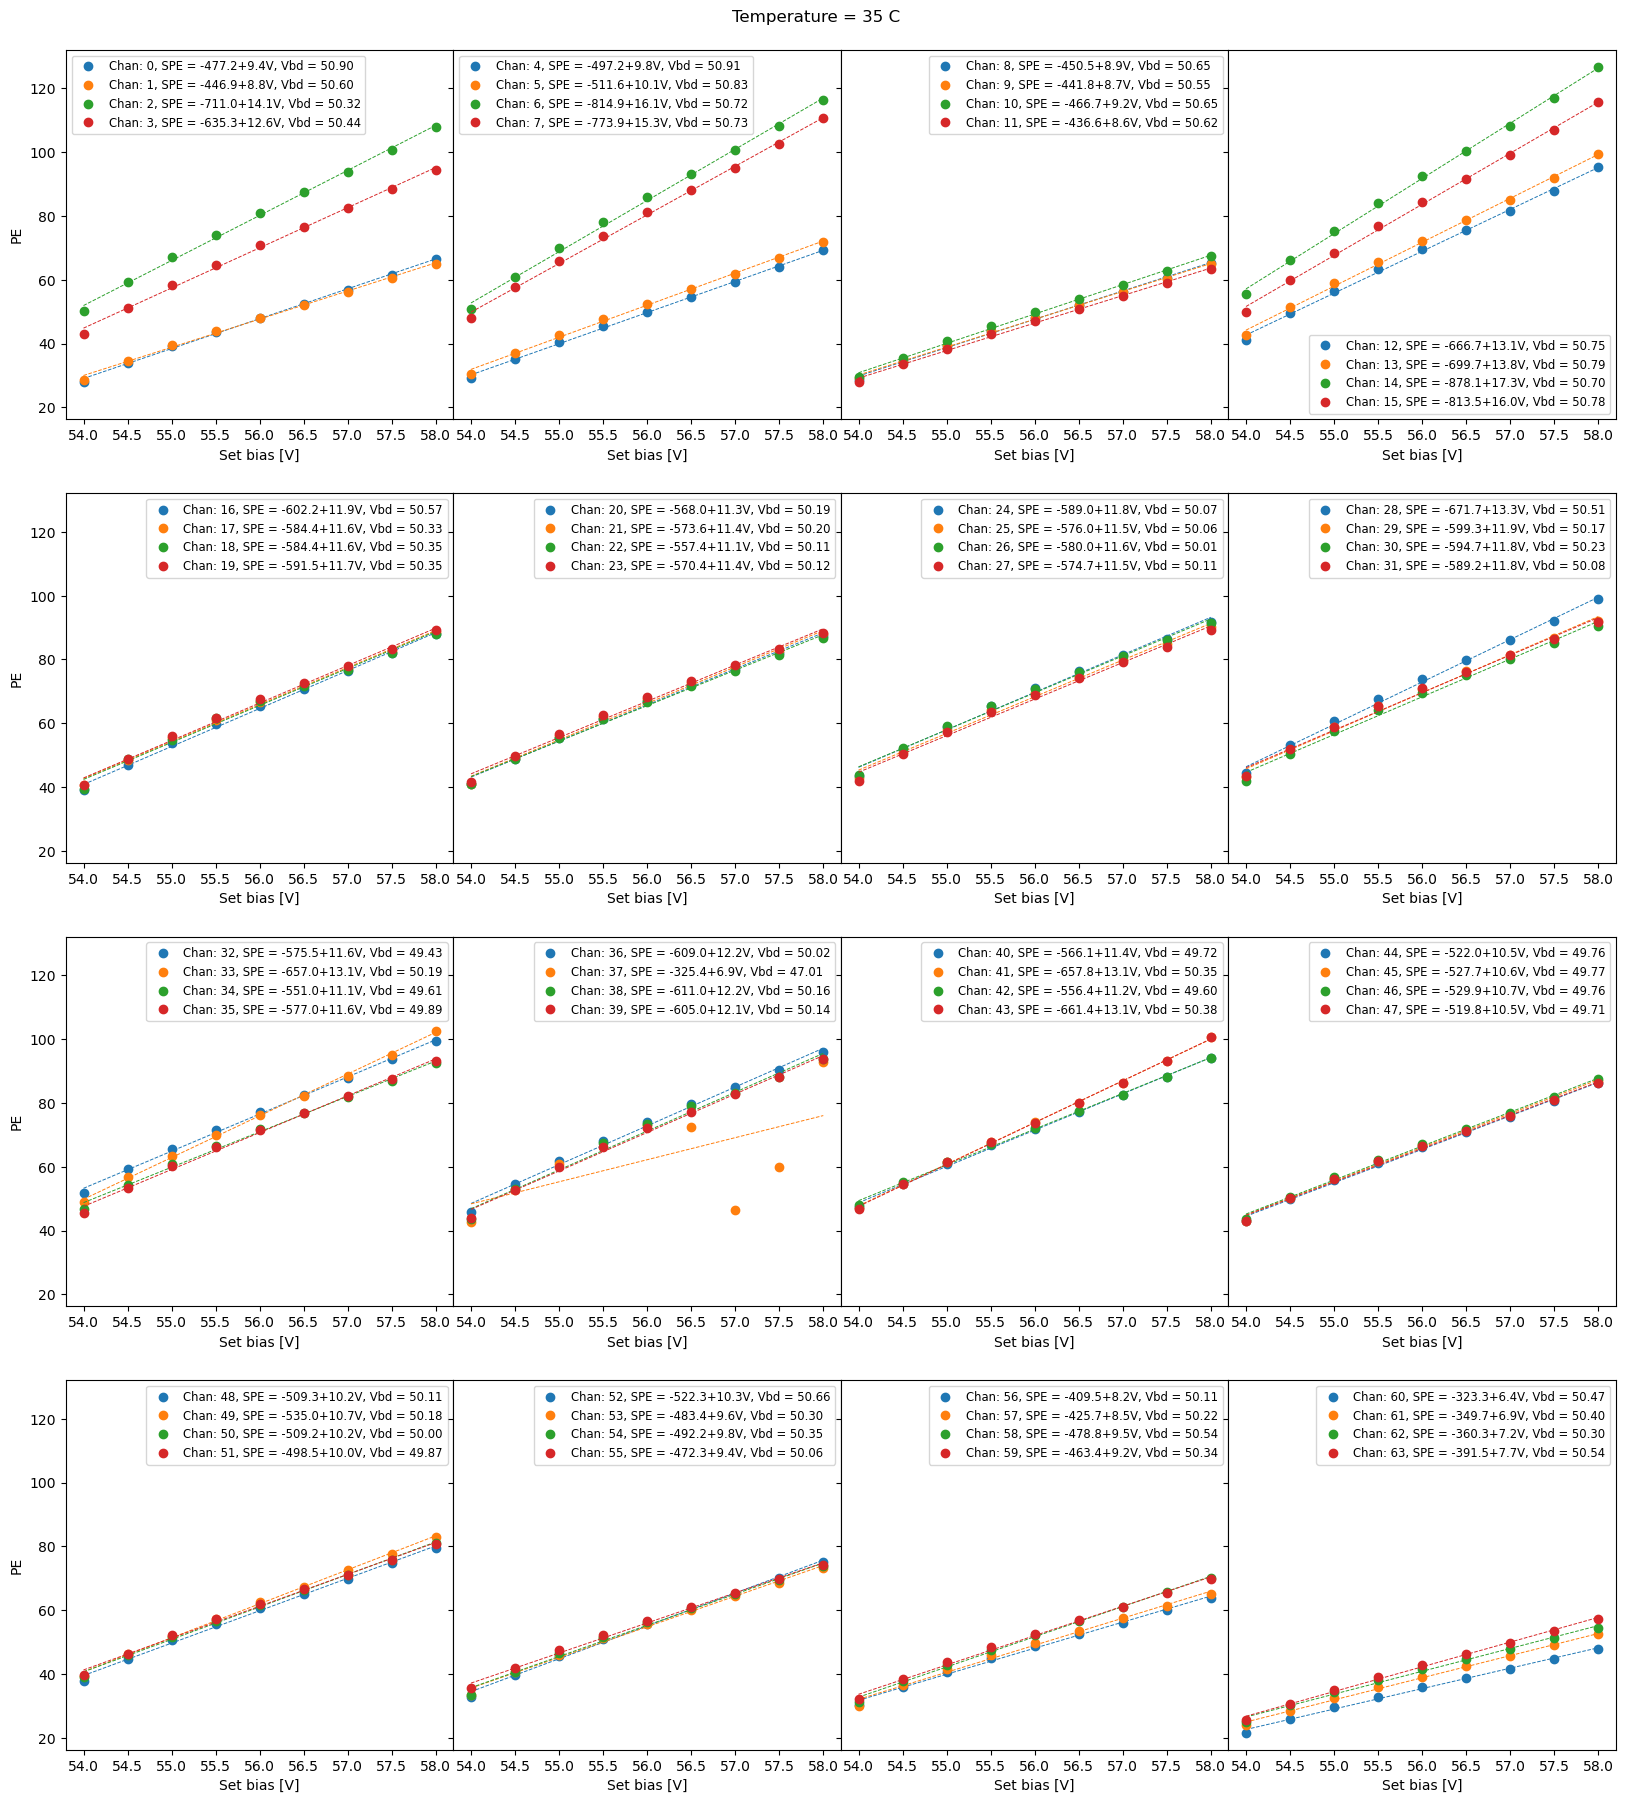

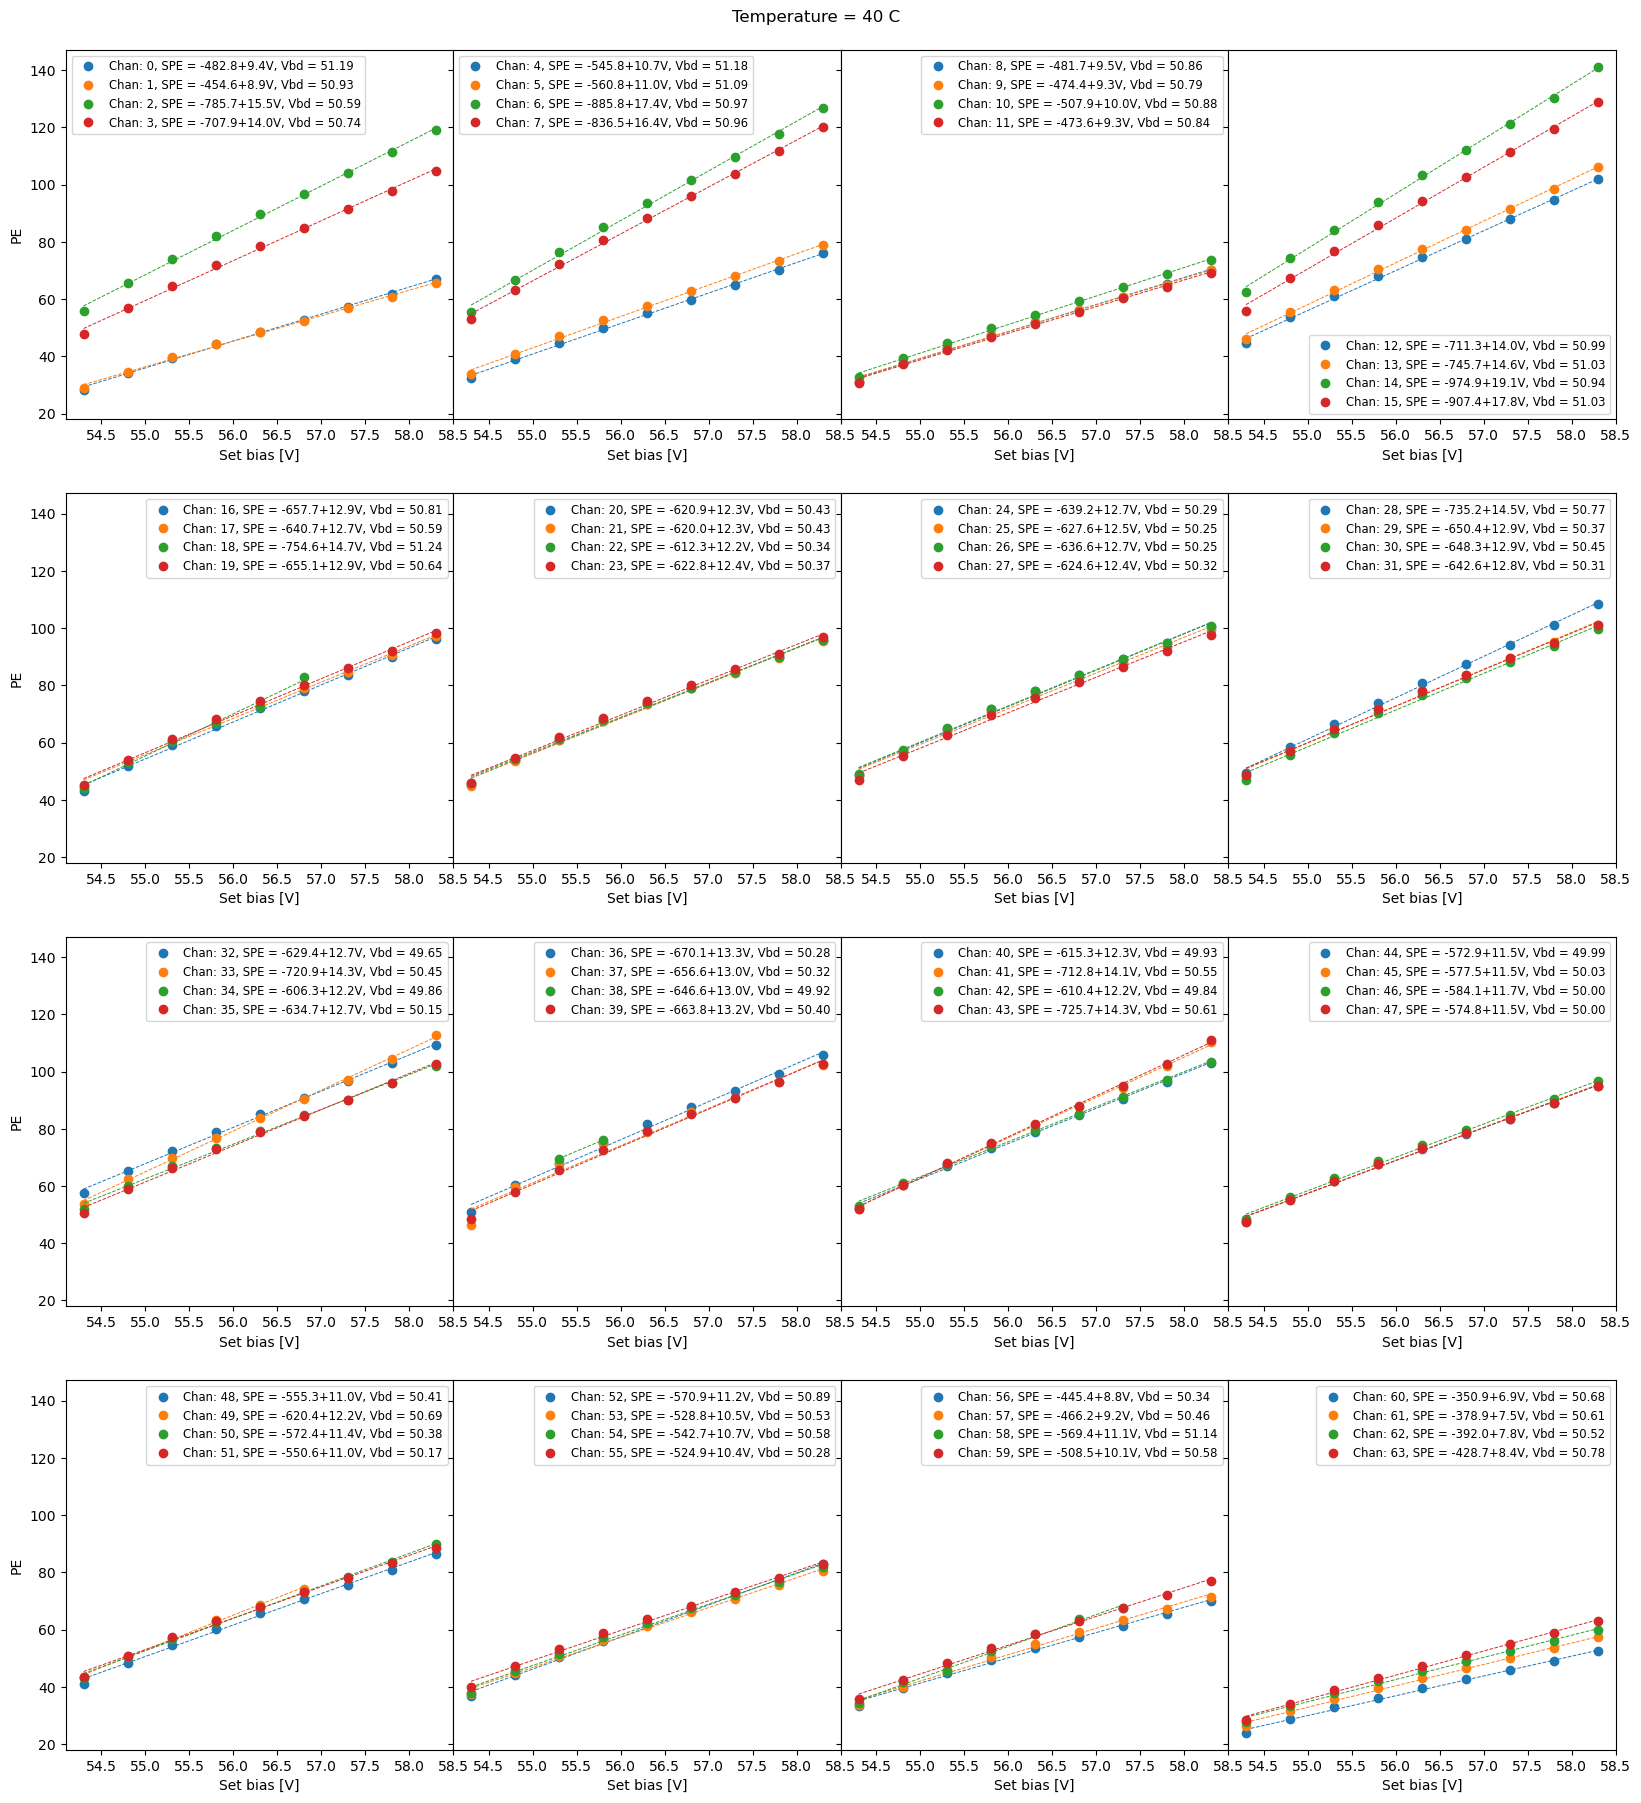

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
    var = 'PEsTemperatureCorrected'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

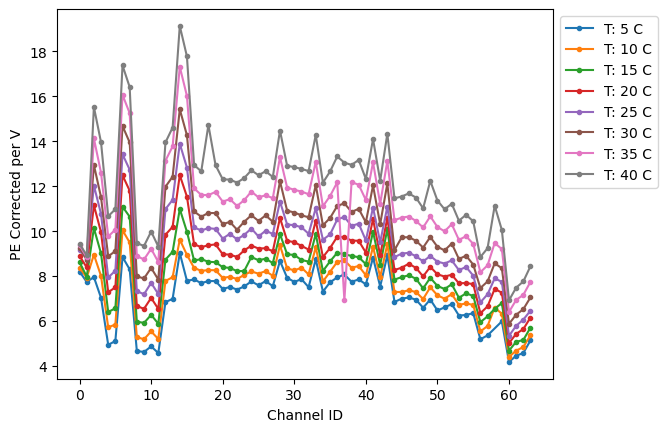

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['slope'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE Corrected per V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

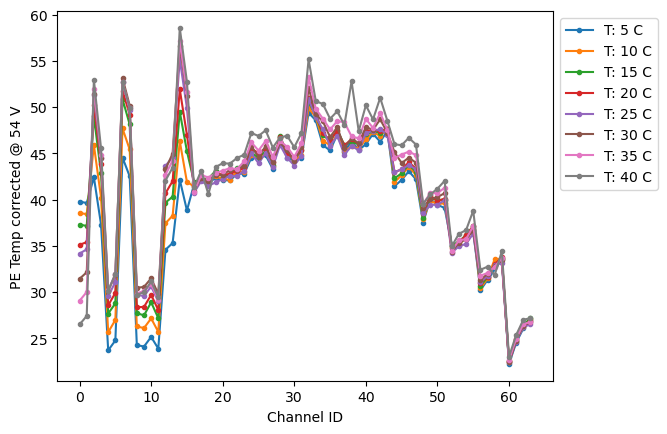

In [5]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['spe_54V_fix'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE Temp corrected @ 54 V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

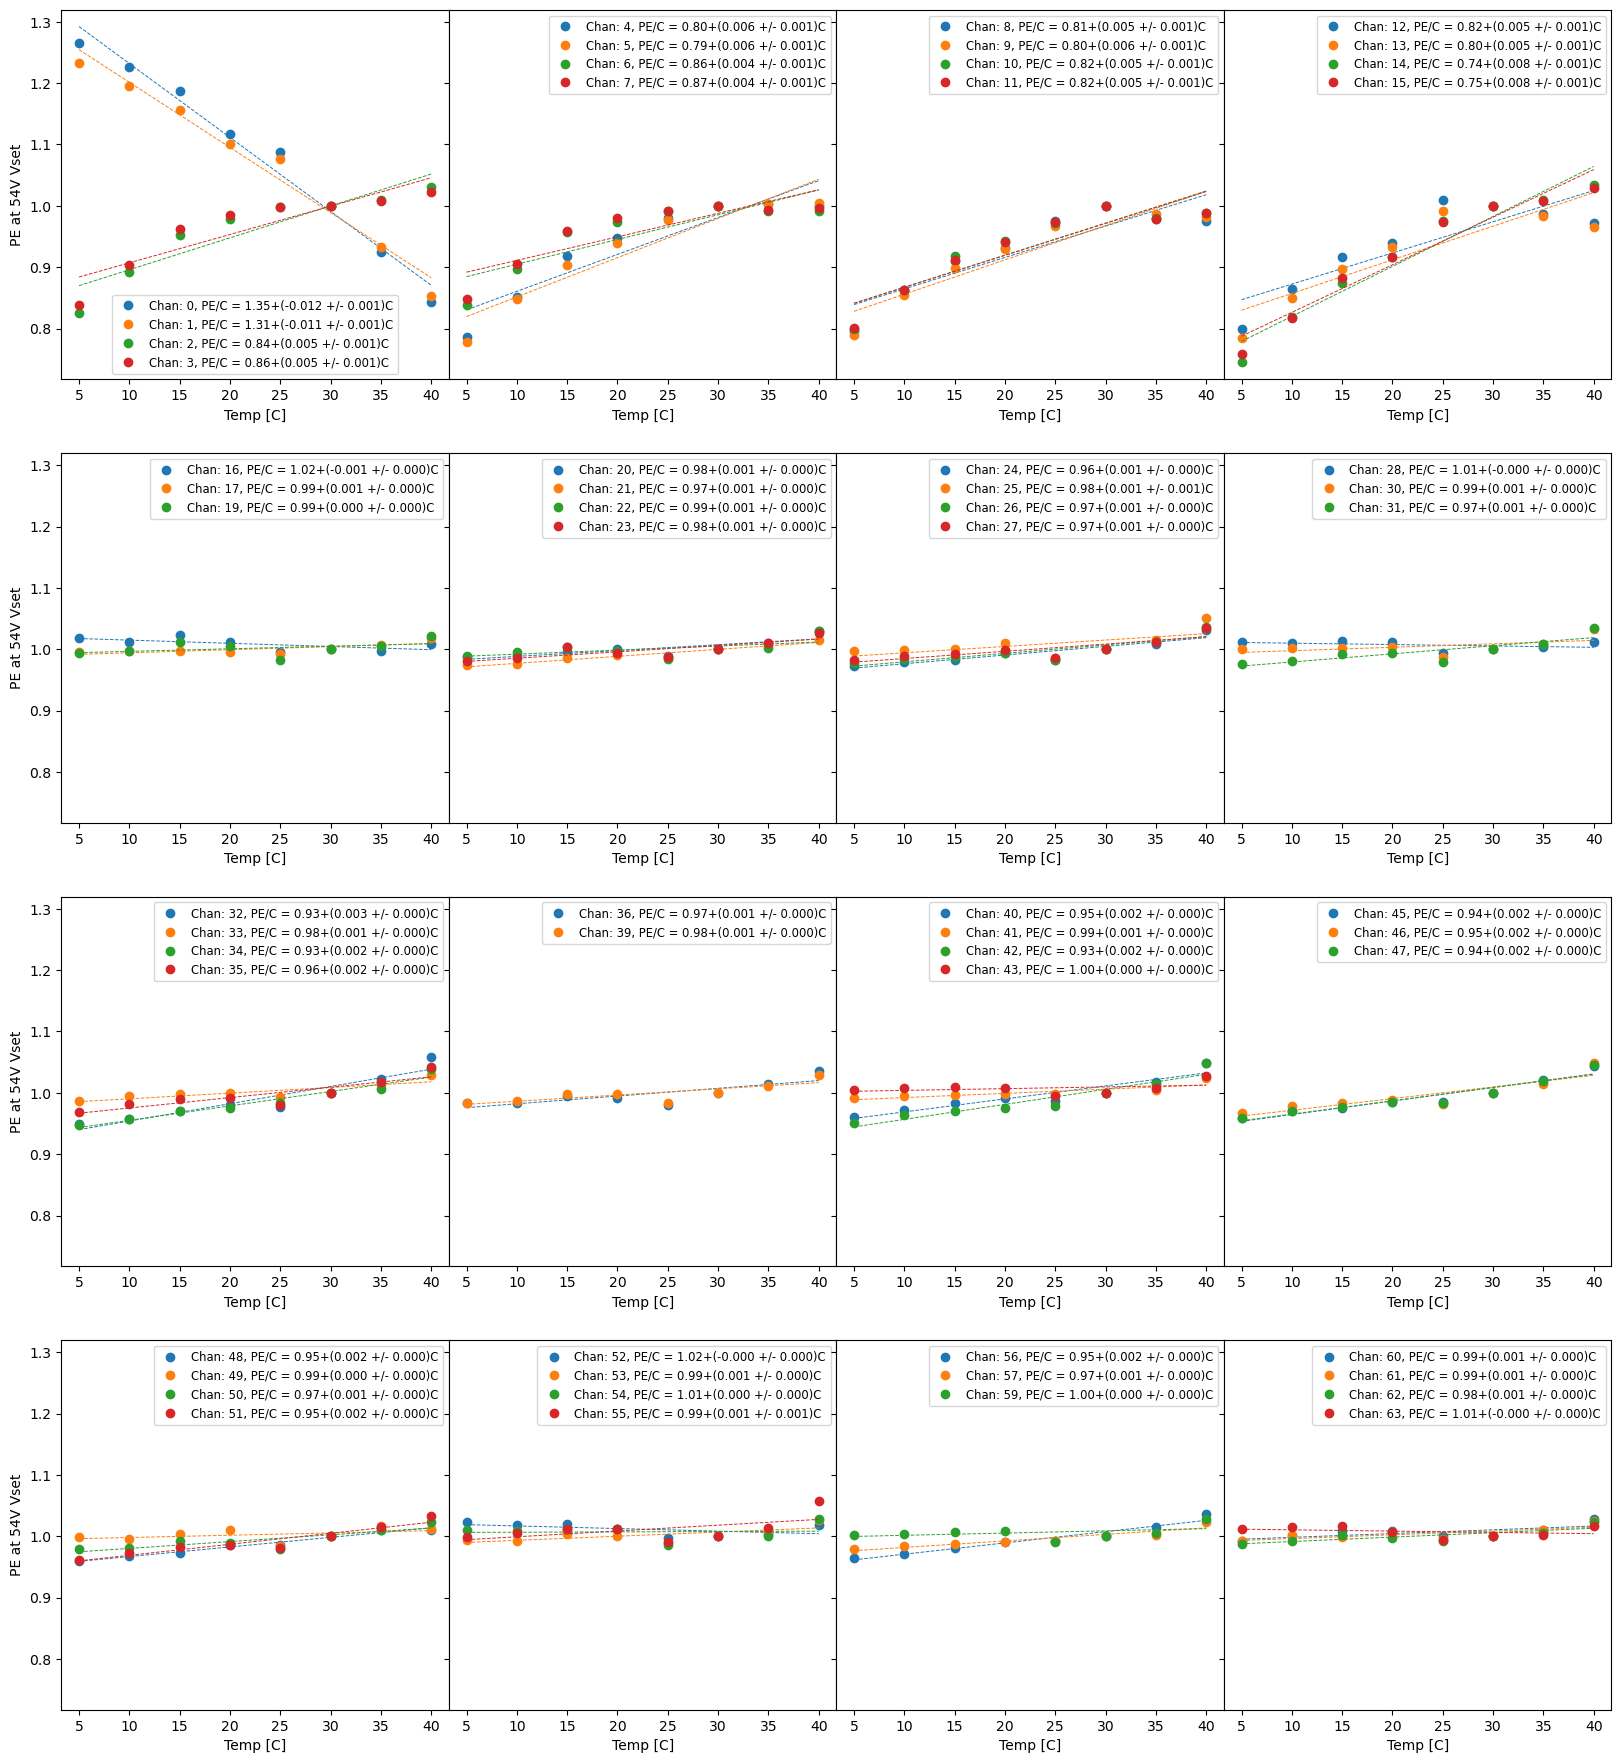

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("PE at 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in badchannels:
            continue
            
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_54V_fix'].to_numpy()
        y=y/y[5]

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, PE/C = %.2f+(%.3f +/- %.3f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

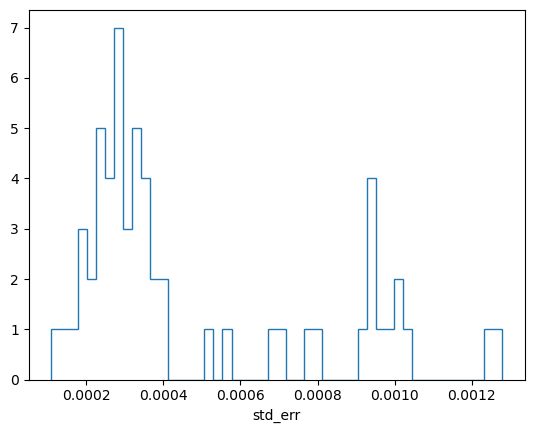

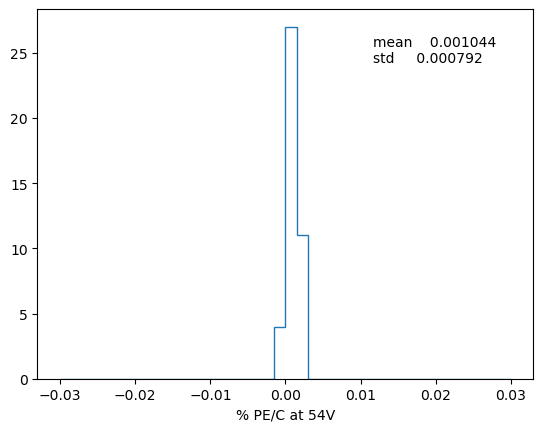

In [7]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50);
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'], histtype='step', bins=40, range=(-0.03,0.03));
plt.xlabel('% PE/C at 54V');
plt.figtext(0.65,0.77, dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'].describe().loc[['mean','std']].to_string());

In [8]:
pd.set_option('display.max_rows', None)
df

chan      slope  temp   intercept   r_value       p_value    std_err  \
0       0   8.199823     5 -403.003315  0.999084  7.659354e-11   0.795747   
1       1   7.738423     5 -378.254386  0.997951  1.278928e-09   1.184417   
2       2   7.955920     5 -387.208522  0.998662  2.879106e-10   0.952446   
3       3   7.028949     5 -342.271760  0.998222  7.788816e-10   1.098959   
4       4   4.939916     5 -243.064035  0.999272  3.423747e-11   0.709975   
5       5   5.107448     5 -251.044698  0.998823  1.838729e-10   0.902092   
6       6   8.849845     5 -433.351732  0.999228  4.204279e-11   0.727621   
7       7   8.300476     5 -405.714295  0.998435  4.982368e-10   1.034704   
8       8   4.667491     5 -227.783624  0.998771  2.142167e-10   0.915460   
9       9   4.620914     5 -225.431113  0.998622  3.192427e-10   0.968938   
10     10   4.870060     5 -237.841957  0.999109  6.941639e-11   0.779670   
11     11   4.574587     5 -223.152352  0.997900  1.394427e-09   1.196760   
12     12   6.841969     5 -334.902178  0.998992  1.068712e-10   0.831208   
13     13   6.985910     5 -341.942760  0.998554  3.784700e-10   0.996153   
14     14   9.028784     5 -445.405163  0.989898  3.377787e-07   2.670529   
15     15   7.788504     5 -381.757685  0.998661  2.885995e-10   0.959551   
16     16   7.850788     5 -382.292726  0.999179  5.213240e-11   0.746186   
17     17   7.686202     5 -372.889961  0.998472  4.582194e-10   1.014750   
18     18   7.779302     5 -378.316761  0.998283  6.889639e-10   1.078403   
19     19   7.777509     5 -377.639233  0.997370  3.063464e-09   1.333614   
20     20   7.428220     5 -359.007362  0.998147  9.001676e-10   1.113595   
21     21   7.515301     5 -363.764615  0.997384  3.005254e-09   1.325781   
22     22   7.400111     5 -356.833443  0.997108  4.270988e-09   1.389117   
23     23   7.536587     5 -364.163220  0.996690  6.848641e-09   1.489674   
24     24   7.763814     5 -374.719542  0.996775  6.251115e-09   1.468602   
25     25   7.590689     5 -365.445062  0.995618  1.825958e-08   1.709099   
26     26   7.778045     5 -375.221460  0.996116  1.198264e-08   1.611820   
27     27   7.552133     5 -364.506500  0.995977  1.354280e-08   1.641279   
28     28   8.674851     5 -421.714328  0.998517  4.133733e-10   1.001934   
29     29   7.925013     5 -383.421679  0.996878  5.581383e-09   1.448369   
30     30   7.740790     5 -373.753762  0.997418  2.871285e-09   1.313880   
31     31   7.863574     5 -380.095955  0.996742  6.481326e-09   1.478438   
32     32   7.507739     5 -356.013915  0.999439  1.372878e-11   0.600398   
33     33   8.748321     5 -423.852089  0.999448  1.296449e-11   0.608435   
34     34   7.310998     5 -348.914292  0.996594  7.569105e-09   1.492640   
35     35   7.725086     5 -371.844665  0.998059  1.058528e-09   1.135154   
36     36   7.940827     5 -381.769532  0.997379  3.028182e-09   1.318278   
37     37   8.070857     5 -390.696020  0.997154  4.036647e-09   1.383285   
38     38   7.745718     5 -371.934674  0.996929  5.266430e-09   1.425555   
39     39   7.851478     5 -378.632303  0.997907  1.378697e-09   1.181183   
40     40   7.632698     5 -366.176808  0.998834  1.779308e-10   0.876343   
41     41   8.821617     5 -429.261558  0.999302  2.953778e-11   0.687454   
42     42   7.535309     5 -360.649416  0.999118  6.695818e-11   0.760152   
43     43   8.935757     5 -435.109716  0.999480  1.058323e-11   0.594003   
44     44   6.848434     5 -328.360360  0.998673  2.796670e-10   0.934412   
45     45   6.995086     5 -335.615736  0.998286  6.853456e-10   1.063134   
46     46   7.047031     5 -337.483842  0.999144  6.039503e-11   0.749467   
47     47   6.950741     5 -333.149064  0.998167  8.665026e-10   1.098357   
48     48   6.591396     5 -318.421860  0.998405  5.333062e-10   1.032658   
49     49   6.956682     5 -335.623725  0.998658  2.909818e-10   0.945575   
50     50   6.469348     5 -309.918039  0.996346  9.675662e-09   1.552133   
5